# Part II: Autoencoders for Anomaly Detection [30 pts]
Implement autoencoder and explore its application for a real-world problem related to anomaly detection.
The final model should achieve a test accuracy of greater than 80%.

**Datasets:** Select ONE dataset based on your preference:
- Yahoo S5 Dataset
- Hard Drive Test Data
- Numenta Anomaly Benchmark

In [1]:
!pip install torchinfo

In [2]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, precision_score, recall_score, f1_score
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
from torchinfo import summary


## Step 1: Data preparation

1. Select and load one dataset from the list above.

In [3]:

df = pd.read_csv("Twitter_volume_GOOG.csv")
print(df.head())



             timestamp  value
0  2015-02-26 21:42:53     35
1  2015-02-26 21:47:53     41
2  2015-02-26 21:52:53     32
3  2015-02-26 21:57:53     36
4  2015-02-26 22:02:53     32


 We will be selecting Numeta Anomaly Benchmark - Twitter Volume dataset for Google .
 The Timestamp column shows us the exact date and time when the tweet volume was recorded. Each timestamp is in the format “YYYY-MM-DD HH:MM:SS” .  
 The value columns represents the tweet volume recorded during the specified timestamp

2. Analyze the dataset and provide the following statistics:
   - Number of samples (time points)
   - Number of features
   - Mean, standard deviation, minimum, and maximum values for each feature (or relevant descriptive statistics depending on the data type)

In [4]:
numSamples = df.shape[0]
numFeatures = df.shape[1]

print("Number of samples :", numSamples)
print("Number of features:", numFeatures)

valueStats = df['value'].describe()
print("\nDescriptive statistics for 'value':")
print(valueStats)

df['timestamp'] = pd.to_datetime(df['timestamp'])
timestamp_min = df['timestamp'].min()
timestamp_max = df['timestamp'].max()

print("\nTimestamp range:")
print("Earliest timestamp:", timestamp_min)
print("Latest timestamp:", timestamp_max)

Number of samples : 15842
Number of features: 2

Descriptive statistics for 'value':
count    15842.000000
mean        20.736397
std         18.564627
min          0.000000
25%         11.000000
50%         16.000000
75%         26.000000
max        465.000000
Name: value, dtype: float64

Timestamp range:
Earliest timestamp: 2015-02-26 21:42:53
Latest timestamp: 2015-04-22 21:47:53


Provide a brief description (2-3 sentences) of the dataset: What does it represent? Where does it come from (provide a link)? What are the key variables?

We will be selecting Numeta Anomaly Benchmark - Twitter Volume dataset for Google .
The Timestamp column shows us the exact date and time when the tweet volume was recorded. Each timestamp is in the format “YYYY-MM-DD HH:MM:SS” .  
The value columns represents the tweet volume recorded during the specified timestamp . The dataset contains 15,842 time points, each recording a timestamp and the corresponding tweet volume. On average, the tweet volume is around 20.74, but theres significant variability (std = 18.56) with counts ranging from 0 to 465. Mostly values fall between 11 and 26, and the data spans from February 26, 2015, to April 22, 2015.

Dataset link : https://www.kaggle.com/datasets/boltzmannbrain/nab?resource=download

3. Create at least three different visualizations to explore the dataset. Provide a short description explaining what each visualization shows.

Visualization and a short description # 1

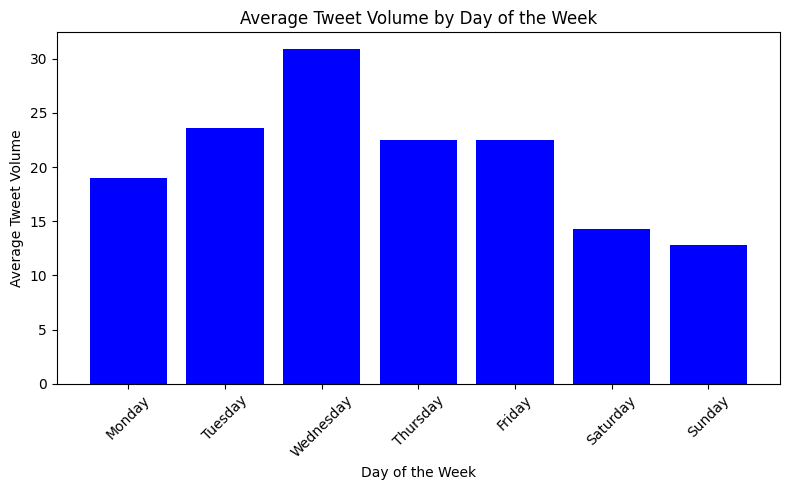

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

df['dayOfWeek'] = df['timestamp'].dt.day_name()
grouped = df.groupby('dayOfWeek')['value'].mean()

order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
grouped = grouped.reindex(order)

# bar chart
plt.figure(figsize=(8, 5))
plt.bar(grouped.index, grouped.values, color='blue')
plt.title("Average Tweet Volume by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Tweet Volume")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This bar chart shows how many Google related tweets happen on average each day of the week. Wednesday has the highest average tweet volume, Sunday has the lowest.

Visualization and a short description # 2

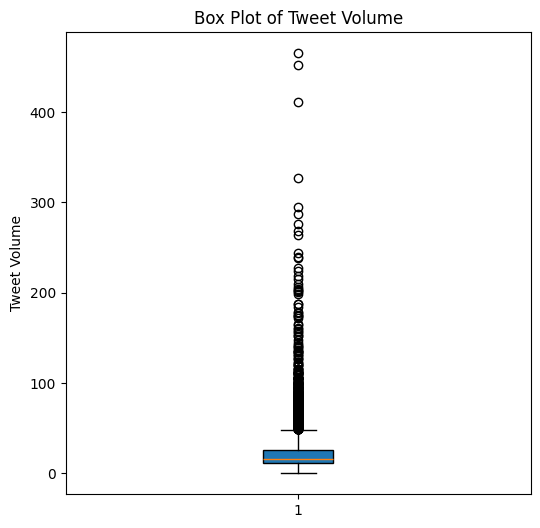

In [ ]:
plt.figure(figsize=(6, 6))
plt.boxplot(df['value'], vert=True, patch_artist=True)
plt.title("Box Plot of Tweet Volume")
plt.ylabel("Tweet Volume")
plt.show()

This box plot shows that most tweet volumes are relatively low, clustered near the bottom,  while the dots above are outliers, showing unusually high tweet activity. The line inside the box is median, and the box edges show the middle 50% of values.

Visualization and a short description # 3

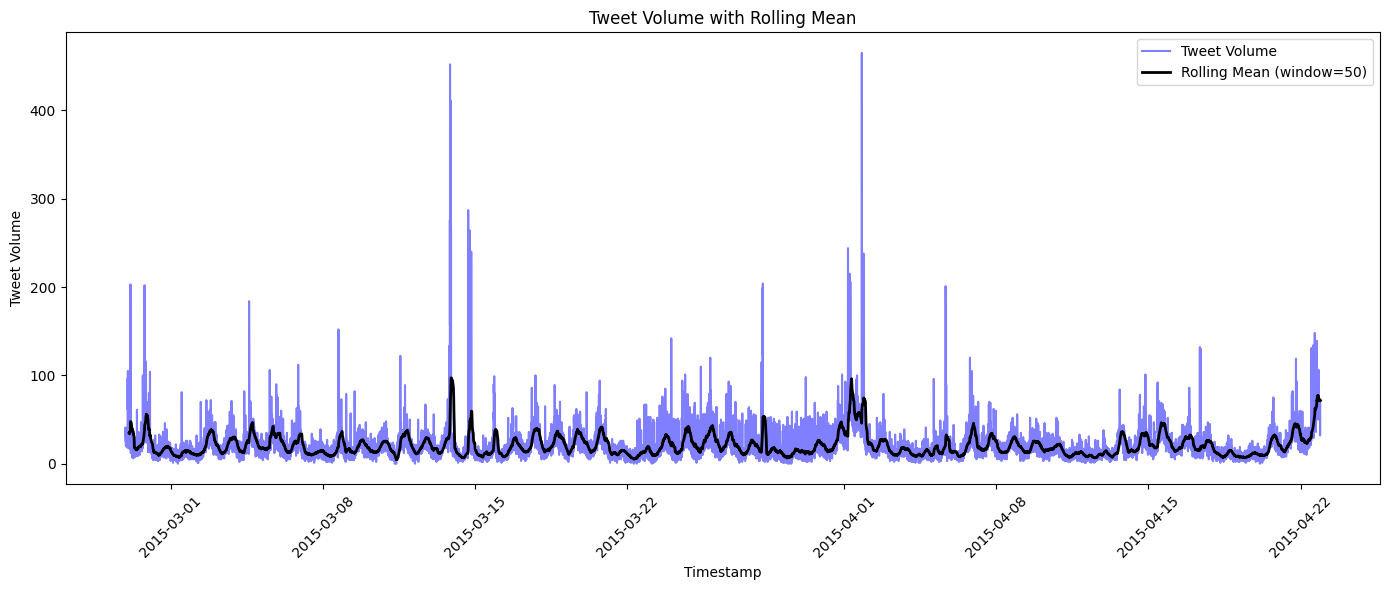

In [ ]:
window_size = 50
df['rollingMean'] = df['value'].rolling(window=window_size).mean()

plt.figure(figsize=(14, 6))
plt.plot(df['timestamp'], df['value'], label='Tweet Volume', color='blue', alpha=0.5)
plt.plot(df['timestamp'], df['rollingMean'], label=f'Rolling Mean (window={window_size})', color='Black', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Tweet Volume')
plt.title('Tweet Volume with Rolling Mean')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This plot shows how tweet volume of Google changed over time from late February to late April 2015. Most of the time, tweet counts remain at a steady level, but there are a few noticeable spikes that reach up to around 400 or more. These spikes shows sudden surges in Twitter activity, possibly due to news or events related to Google. The black line is a 50-point rolling average of the tweet volume, smoothing out the short-term spikes and showing the overall trend more clearly.

4. Identify any missing values (e.g. using pandas.isnull().sum()). Handle any missing values (imputation or removal). Common imputation methods include: forward/backward fill, mean/median imputation, linear interpolation).

In [5]:
print("Missing values for value :")
print(df['value'].isnull().sum())

print("Missing values for timestamp :")
print(df['timestamp'].isnull().sum())

Missing values for value :
0
Missing values for timestamp :
0


There are no missing values in the dataset we chose , so there is no imputation required .

5. Preprocess the dataset.

   a. Normalize the data.

we already did one normalisation earlier where we converted the timestamp to datetime

In [6]:
scaler = StandardScaler()
df['N_Value'] = scaler.fit_transform(df[['value']])

In [7]:
print(df['N_Value'].head())


0    0.768346
1    1.091551
2    0.606743
3    0.822213
4    0.606743
Name: N_Value, dtype: float64


   b. [If needed] Address class imbalance in the target column. Possible solutions: oversampling; undersampling; data augmentation techniques for the minority class; assign higher weights to the minority class and lower weights to the majority class, etc.

There is no class imbalance in the target columns

   c. [If needed] Convert target variable needs to numerical format. You can use one-hot encoding. However, if you use torch.nn.CrossEntropyLoss for your network, it expects class indices (0, 1, 2) directly, not one-hot encoded vectors. Therefore, ensure your labels are integer tensors (e.g., torch.LongTensor).

We have already converted  our variable to  numerical format . again , not required.

6. Split the dataset into training, testing and validation sets. You can use train_test_split from scikit-learn.

In [8]:
train_val, test = train_test_split(df, test_size=0.2, shuffle=False)
train, val = train_test_split(train_val, test_size=0.25, shuffle=False)

print("Training set shape:", train.shape)
print("Validation set shape:", val.shape)
print("Test set shape:", test.shape)

Training set shape: (9504, 3)
Validation set shape: (3169, 3)
Test set shape: (3169, 3)


## Step 2: Autoencoder model building

1. Choose and implement one of the following: Autoencoder,Variational Autoencoder (VAE) or other version of Autoencoder for anomaly detection.

2. Experiment with different architectures. Build and train 3 different autoencoder architectures for anomaly detection. Consider experimenting with:
   - Different layer types (Dense, LSTM for time series, Conv1D for sequential data)
   - Number of hidden layers and units
   - Activation functions (ReLU, sigmoid)
   - Print model summary using torchinfo.summary

### Model 1 Architecture ###

In [11]:
class BaseAutoencoder(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=50, latent_dim=10):
        super(BaseAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction

input_dim = 100
model = BaseAutoencoder(input_dim=input_dim, hidden_dim=50, latent_dim=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = model.to(device)

summary(model, input_size=(32, input_dim))

Using device: cuda


Layer (type:depth-idx)                   Output Shape              Param #
BaseAutoencoder                          [32, 100]                 --
├─Sequential: 1-1                        [32, 10]                  --
│    └─Linear: 2-1                       [32, 50]                  5,050
│    └─ReLU: 2-2                         [32, 50]                  --
│    └─Linear: 2-3                       [32, 10]                  510
├─Sequential: 1-2                        [32, 100]                 --
│    └─Linear: 2-4                       [32, 50]                  550
│    └─ReLU: 2-5                         [32, 50]                  --
│    └─Linear: 2-6                       [32, 100]                 5,100
│    └─Sigmoid: 2-7                      [32, 100]                 --
Total params: 11,210
Trainable params: 11,210
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.36
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.04
Estimated Total Size (MB

### Model 2 Architecture ###

In [12]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, latent_dim=32, num_layers=1):
        super(LSTMAutoencoder, self).__init__()
        # Encoder
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        self.fc_enc = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc_dec = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        encoder_output, (h_n, c_n) = self.encoder_lstm(x)
        latent = self.fc_enc(h_n[-1])

        decoder_input = self.fc_dec(latent).unsqueeze(1).repeat(1, seq_len, 1)
        decoder_output, _ = self.decoder_lstm(decoder_input)
        return decoder_output

lstm_autoencoder = LSTMAutoencoder(input_dim=1, hidden_dim=64, latent_dim=32, num_layers=1)
lstm_autoencoder = lstm_autoencoder.to(device)
summary(lstm_autoencoder, input_size=(32, 100, 1))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMAutoencoder                          [32, 100, 1]              --
├─LSTM: 1-1                              [32, 100, 64]             17,152
├─Linear: 1-2                            [32, 32]                  2,080
├─Linear: 1-3                            [32, 64]                  2,112
├─LSTM: 1-4                              [32, 100, 1]              268
Total params: 21,612
Trainable params: 21,612
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 55.88
Input size (MB): 0.01
Forward/backward pass size (MB): 1.69
Params size (MB): 0.09
Estimated Total Size (MB): 1.79

### Model 3 Architecture ###

In [27]:
import torch.nn.functional as F
class Conv1DAutoencoder(nn.Module):
    def __init__(self):
        super(Conv1DAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.LayerNorm([64, 50]),
            nn.ELU(),
            nn.Dropout(0.1),

            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LayerNorm([128, 25]),
            nn.ELU(),
            nn.Dropout(0.2),

            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.LayerNorm([256, 13]),
            nn.ELU(),
            nn.Dropout(0.2),

            nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.LayerNorm([512, 7]),
            nn.ELU()
        )

        self.bottleneck_fc1 = nn.Linear(512 * 7, 256)
        self.bottleneck_fc2 = nn.Linear(256, 512 * 7)

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.LayerNorm([256, 14]),
            nn.ELU(),

            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LayerNorm([128, 28]),
            nn.ELU(),

            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LayerNorm([64, 56]),
            nn.ELU(),

            nn.ConvTranspose1d(64, 1, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        b, c, t = encoded.size()
        bottleneck = encoded.view(b, -1)
        bottleneck = F.elu(self.bottleneck_fc1(bottleneck))
        bottleneck = self.bottleneck_fc2(bottleneck)
        bottleneck = bottleneck.view(b, c, t)
        decoded = self.decoder(bottleneck)

        if decoded.size(-1) > x.size(-1):
            decoded = decoded[:, :, :x.size(-1)]
        elif decoded.size(-1) < x.size(-1):
            decoded = F.pad(decoded, (0, x.size(-1) - decoded.size(-1)))

        return decoded

window_size = 100
conv1d_autoencoder = Conv1DAutoencoder().to(device)
summary(conv1d_autoencoder, input_size=(32, 1, window_size))


Layer (type:depth-idx)                   Output Shape              Param #
Conv1DAutoencoder                        [32, 1, 100]              --
├─Sequential: 1-1                        [32, 512, 7]              --
│    └─Conv1d: 2-1                       [32, 64, 50]              512
│    └─LayerNorm: 2-2                    [32, 64, 50]              6,400
│    └─ELU: 2-3                          [32, 64, 50]              --
│    └─Dropout: 2-4                      [32, 64, 50]              --
│    └─Conv1d: 2-5                       [32, 128, 25]             41,088
│    └─LayerNorm: 2-6                    [32, 128, 25]             6,400
│    └─ELU: 2-7                          [32, 128, 25]             --
│    └─Dropout: 2-8                      [32, 128, 25]             --
│    └─Conv1d: 2-9                       [32, 256, 13]             98,560
│    └─LayerNorm: 2-10                   [32, 256, 13]             6,656
│    └─ELU: 2-11                         [32, 256, 13]             

3. Model training and hyperparameter tuning:
   - Choose an appropriate loss function and optimizer (e.g., Adam).
   - Train your model and monitor its performance on the training and validation sets.
   - Tune hyperparameters (learning rate, batch size, number of epochs, hidden units, dropout rate) using the validation set.
   - Plot the training and validation loss and accuracy curves over epochs. Analyze the plots for signs of overfitting or underfitting. Adjust your model or hyperparameters if needed.

Epoch 1/20 - Train Loss: 0.8623, Val Loss: 0.9603
Epoch 2/20 - Train Loss: 0.7753, Val Loss: 0.9328
Epoch 3/20 - Train Loss: 0.7695, Val Loss: 0.9250
Epoch 4/20 - Train Loss: 0.7661, Val Loss: 0.9212
Epoch 5/20 - Train Loss: 0.7613, Val Loss: 0.9150
Epoch 6/20 - Train Loss: 0.7565, Val Loss: 0.9133
Epoch 7/20 - Train Loss: 0.7531, Val Loss: 0.9100
Epoch 8/20 - Train Loss: 0.7495, Val Loss: 0.9080
Epoch 9/20 - Train Loss: 0.7468, Val Loss: 0.9079
Epoch 10/20 - Train Loss: 0.7452, Val Loss: 0.9068
Epoch 11/20 - Train Loss: 0.7438, Val Loss: 0.9066
Epoch 12/20 - Train Loss: 0.7425, Val Loss: 0.9059
Epoch 13/20 - Train Loss: 0.7412, Val Loss: 0.9052
Epoch 14/20 - Train Loss: 0.7399, Val Loss: 0.9035
Epoch 15/20 - Train Loss: 0.7389, Val Loss: 0.9048
Epoch 16/20 - Train Loss: 0.7380, Val Loss: 0.9040
Epoch 17/20 - Train Loss: 0.7373, Val Loss: 0.9029
Epoch 18/20 - Train Loss: 0.7367, Val Loss: 0.9023
Epoch 19/20 - Train Loss: 0.7361, Val Loss: 0.9031
Epoch 20/20 - Train Loss: 0.7357, Val Lo

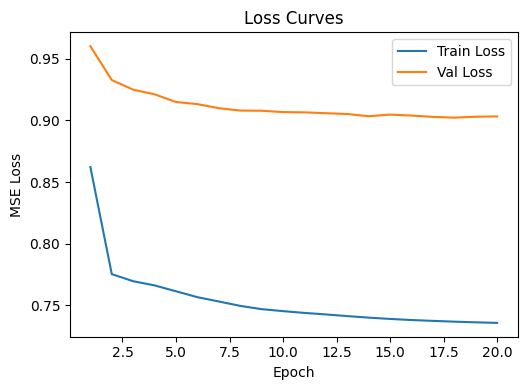

In [25]:
#BaseAutoEncoder Model :
def createSliding_windows(series, window_size):
    windows = []
    for i in range(len(series) - window_size + 1):
        windows.append(series[i : i + window_size])
    return np.array(windows)

window_size = 100

train_series = train['N_Value'].values
val_series   = val['N_Value'].values

train_windows = createSliding_windows(train_series, window_size)
val_windows   = createSliding_windows(val_series, window_size)

train_tensor = torch.tensor(train_windows, dtype=torch.float32)
val_tensor   = torch.tensor(val_windows, dtype=torch.float32)

batch_size = 32
train_dataset = TensorDataset(train_tensor)
val_dataset   = TensorDataset(val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    for batch in train_loader:
        inputs = batch[0].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * inputs.size(0)

    epoch_train_loss /= len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch[0].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            epoch_val_loss += loss.item() * inputs.size(0)
    epoch_val_loss /= len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

# training and val loss curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss Curves")
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/20 - Train Loss: 0.7661, Val Loss: 0.9009
Epoch 2/20 - Train Loss: 0.7636, Val Loss: 0.9009
Epoch 3/20 - Train Loss: 0.7636, Val Loss: 0.9019
Epoch 4/20 - Train Loss: 0.7637, Val Loss: 0.9009
Epoch 5/20 - Train Loss: 0.7638, Val Loss: 0.9008
Epoch 6/20 - Train Loss: 0.7636, Val Loss: 0.9008
Epoch 7/20 - Train Loss: 0.7635, Val Loss: 0.9014
Epoch 8/20 - Train Loss: 0.7637, Val Loss: 0.9014
Epoch 9/20 - Train Loss: 0.7638, Val Loss: 0.9001
Epoch 10/20 - Train Loss: 0.7620, Val Loss: 0.8982
Epoch 11/20 - Train Loss: 0.7609, Val Loss: 0.9083
Epoch 12/20 - Train Loss: 0.7521, Val Loss: 0.8699
Epoch 13/20 - Train Loss: 0.7409, Val Loss: 0.8670
Epoch 14/20 - Train Loss: 0.7392, Val Loss: 0.8768
Epoch 15/20 - Train Loss: 0.7383, Val Loss: 0.8676
Epoch 16/20 - Train Loss: 0.7373, Val Loss: 0.8627
Epoch 17/20 - Train Loss: 0.7368, Val Loss: 0.8697
Epoch 18/20 - Train Loss: 0.7369, Val Loss: 0.8668
Epoch 19/20 - Train Loss: 0.7356, Val Loss: 0.8535
Epoch 20/20 - Train Loss: 0.7346, Val Lo

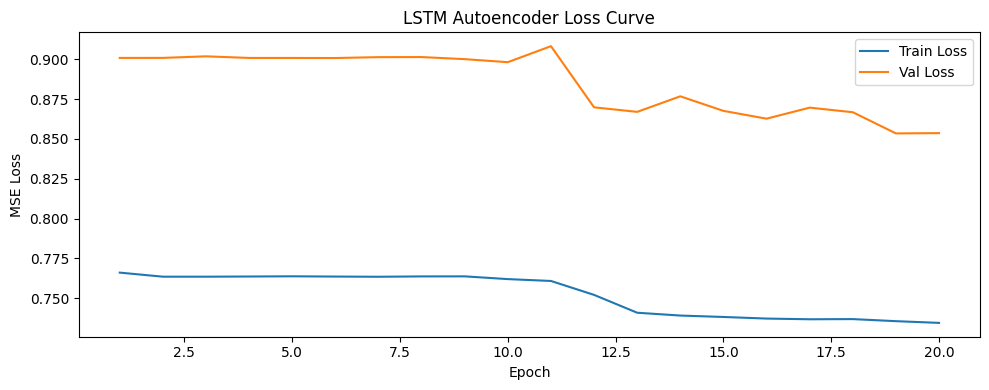

In [ ]:
#LSTMAutoEncoder
window_size = 100

train_series = train['N_Value'].values
val_series   = val['N_Value'].values

train_windows = createSliding_windows(train_series, window_size)
val_windows   = createSliding_windows(val_series, window_size)
train_windows = np.expand_dims(train_windows, axis=2)
val_windows   = np.expand_dims(val_windows, axis=2)

train_tensor = torch.tensor(train_windows, dtype=torch.float32)
val_tensor   = torch.tensor(val_windows, dtype=torch.float32)

batch_size = 32
train_dataset = TensorDataset(train_tensor)
val_dataset   = TensorDataset(val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_autoencoder.parameters(), lr=1e-3)

num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    lstm_autoencoder.train()
    epoch_train_loss = 0.0
    for batch in train_loader:
        inputs = batch[0].to(device)
        optimizer.zero_grad()
        outputs = lstm_autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * inputs.size(0)

    epoch_train_loss /= len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    lstm_autoencoder.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch[0].to(device)
            outputs = lstm_autoencoder(inputs)
            loss = criterion(outputs, inputs)
            epoch_val_loss += loss.item() * inputs.size(0)

    epoch_val_loss /= len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

# training and val loss curves
plt.figure(figsize=(10,4))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("LSTM Autoencoder Loss Curve")
plt.legend()
plt.tight_layout()
plt.show()

Epoch 1/50 - Train Loss: 0.7400, Val Loss: 0.8562
Epoch 2/50 - Train Loss: 0.6741, Val Loss: 0.8418
Epoch 3/50 - Train Loss: 0.6618, Val Loss: 0.8382
Epoch 4/50 - Train Loss: 0.6578, Val Loss: 0.8358
Epoch 5/50 - Train Loss: 0.6559, Val Loss: 0.8350
Epoch 6/50 - Train Loss: 0.6545, Val Loss: 0.8344
Epoch 7/50 - Train Loss: 0.6537, Val Loss: 0.8338
Epoch 8/50 - Train Loss: 0.6530, Val Loss: 0.8334
Epoch 9/50 - Train Loss: 0.6525, Val Loss: 0.8332
Epoch 10/50 - Train Loss: 0.6520, Val Loss: 0.8331
Epoch 11/50 - Train Loss: 0.6517, Val Loss: 0.8333
Epoch 12/50 - Train Loss: 0.6514, Val Loss: 0.8326
Epoch 13/50 - Train Loss: 0.6512, Val Loss: 0.8325
Epoch 14/50 - Train Loss: 0.6510, Val Loss: 0.8326
Epoch 15/50 - Train Loss: 0.6508, Val Loss: 0.8325
Epoch 16/50 - Train Loss: 0.6507, Val Loss: 0.8324
Epoch 17/50 - Train Loss: 0.6504, Val Loss: 0.8322
Epoch 18/50 - Train Loss: 0.6503, Val Loss: 0.8323
Epoch 19/50 - Train Loss: 0.6502, Val Loss: 0.8322
Epoch 20/50 - Train Loss: 0.6500, Val Lo

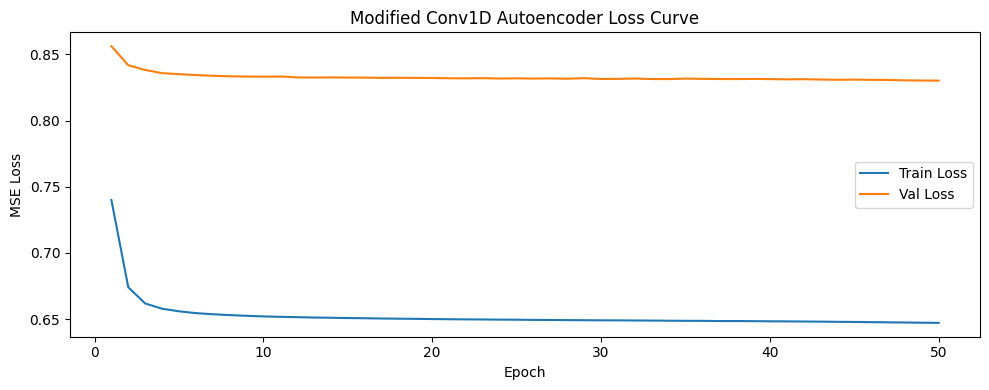

In [28]:
def createSliding_windows(series, window_size):
    windows = []
    for i in range(len(series) - window_size + 1):
        windows.append(series[i : i + window_size])
    return np.array(windows)


train_series = train['N_Value'].values
val_series   = val['N_Value'].values

train_windows = createSliding_windows(train_series, window_size)
val_windows   = createSliding_windows(val_series, window_size)

train_windows = np.expand_dims(train_windows, axis=1)
val_windows   = np.expand_dims(val_windows, axis=1)

train_tensor = torch.tensor(train_windows, dtype=torch.float32)
val_tensor   = torch.tensor(val_windows, dtype=torch.float32)

batch_size = 32
train_dataset = TensorDataset(train_tensor)
val_dataset   = TensorDataset(val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.MSELoss()
optimizer = optim.Adam(conv1d_autoencoder.parameters(), lr=1e-4)

num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    conv1d_autoencoder.train()
    epoch_train_loss = 0.0
    for batch in train_loader:
        inputs = batch[0].to(device)
        optimizer.zero_grad()
        outputs = conv1d_autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * inputs.size(0)

    epoch_train_loss /= len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    conv1d_autoencoder.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch[0].to(device)
            outputs = conv1d_autoencoder(inputs)
            loss = criterion(outputs, inputs)
            epoch_val_loss += loss.item() * inputs.size(0)

    epoch_val_loss /= len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

# === Plotting ===
plt.figure(figsize=(10,4))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Modified Conv1D Autoencoder Loss Curve")
plt.legend()
plt.tight_layout()
plt.show()

Conv1D Autoencoder achieves the best result among the three we tested .

4. Save the weights of the trained neural network that provides the best results. Check saving and loading models (PyTorch)

In [ ]:
model_path = "conv1d_autoencoder_weights.pth"
torch.save(conv1d_autoencoder.state_dict(), model_path)

loaded_model = Conv1DAutoencoder()
loaded_model.load_state_dict(torch.load("conv1d_autoencoder_weights.pth"))
loaded_model = loaded_model.to(device)
loaded_model.eval()

print("Model loaded successfully")

Model loaded successfully


## Step 3: Evaluation and analysis

1. Evaluate your best model on the test set. Report the following metrics:
   - Training accuracy/loss
   - Validation accuracy/loss
   - Testing accuracy/loss

In [29]:
def evaluate_loss(model, dataloader, name):
    conv1d_autoencoder.eval()
    total_loss = 0.0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch[0].to(device)
            outputs = conv1d_autoencoder(inputs)
            loss = criterion(outputs, inputs)
            total_loss += loss.item() * inputs.size(0)
    average_loss = total_loss / len(dataloader.dataset)
    print(f"{name} Loss: {average_loss:.4f}")
    return average_loss

test_series = test['N_Value'].values
test_windows = createSliding_windows(test_series, window_size)
test_windows = np.expand_dims(test_windows, axis=1)
test_tensor = torch.tensor(test_windows, dtype=torch.float32)
test_dataset = TensorDataset(test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_loss = evaluate_loss(conv1d_autoencoder, train_loader, "Training")
val_loss   = evaluate_loss(conv1d_autoencoder, val_loader, "Validation")
test_loss  = evaluate_loss(conv1d_autoencoder, test_loader, "Testing")

Training Loss: 0.6460
Validation Loss: 0.8301
Testing Loss: 0.3525


2. Depending on your chosen dataset, report relevant metrics like:
   - Regression: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), R-squared (coefficient of determination). Use sklearn.metrics.
   - Classification: Precision, Recall, F1-score.

In [31]:
conv1d_autoencoder.eval()
all_inputs = []
all_outputs = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)
        outputs = conv1d_autoencoder(inputs)
        all_inputs.append(inputs.cpu().numpy())
        all_outputs.append(outputs.cpu().numpy())

all_inputs = np.concatenate(all_inputs, axis=0)
all_outputs = np.concatenate(all_outputs, axis=0)

y_true = all_inputs.flatten()
y_pred = all_outputs.flatten()

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred)** 0.5
r2 = r2_score(y_true, y_pred)

print("Regression Metrics:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²    : {r2:.4f}")


Regression Metrics:
MAE  : 0.3975
RMSE : 0.5938
R²    : 0.4693


3. Provide the following plots:
   - Plot training and validation accuracy/loss curves over epochs.
   - Plot the distribution of the reconstruction errors (i.e., differences between input and output data points).

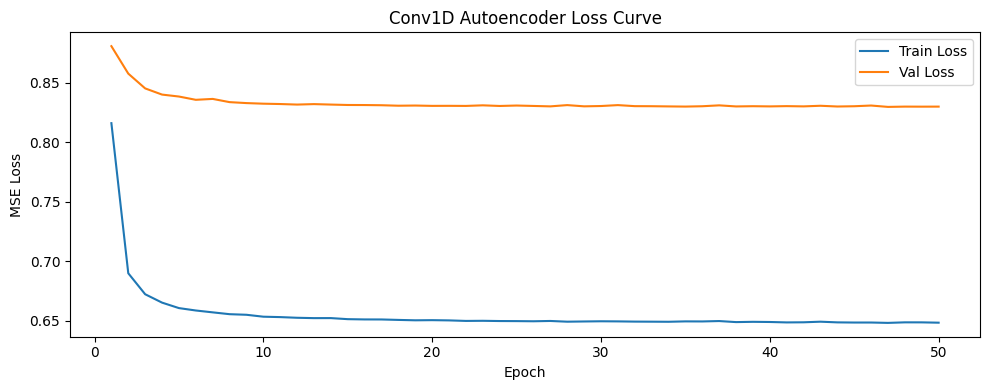

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Conv1D Autoencoder Loss Curve")
plt.legend()
plt.tight_layout()
plt.show()

90th Percentile Threshold: 1.6247
Z-score Threshold: 6.8233
Final (Hybrid) Threshold Used: 1.6247
Number of anomalies detected: 307


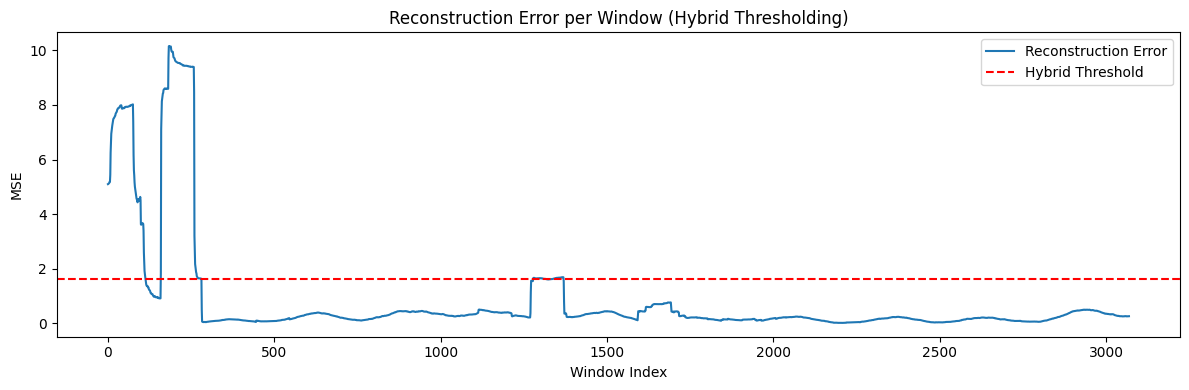

In [33]:
conv1d_autoencoder.eval()
reconstruction_errors = []

with torch.no_grad():
    for batch in val_loader:
        inputs = batch[0].to(device)
        outputs = conv1d_autoencoder(inputs)
        errors = torch.mean((outputs - inputs) ** 2, dim=(1, 2))
        reconstruction_errors.extend(errors.cpu().numpy())

reconstruction_errors = np.array(reconstruction_errors)

# Calculate both thresholds
threshold_90 = np.percentile(reconstruction_errors, 90)
mean = np.mean(reconstruction_errors)
std = np.std(reconstruction_errors)
threshold_z = mean + 3 * std

# Use the lower of the two
final_threshold = min(threshold_90, threshold_z)
anomalies = reconstruction_errors > final_threshold

print(f"90th Percentile Threshold: {threshold_90:.4f}")
print(f"Z-score Threshold: {threshold_z:.4f}")
print(f"Final (Hybrid) Threshold Used: {final_threshold:.4f}")
print(f"Number of anomalies detected: {np.sum(anomalies)}")

# Plot
plt.figure(figsize=(12, 4))
plt.plot(reconstruction_errors, label='Reconstruction Error')
plt.axhline(final_threshold, color='red', linestyle='--', label='Hybrid Threshold')
plt.title("Reconstruction Error per Window (Hybrid Thresholding)")
plt.xlabel("Window Index")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.show()

This plot shows the reconstruction error (MSE) for each input window in the test data.
The red dashed line is the threshold (90th percentile), and any point above it is considered an anomaly.
We can see clear spikes early on, where the reconstruction error is very high,these are the detected anomalies.

Anomalies detected in test set: 73


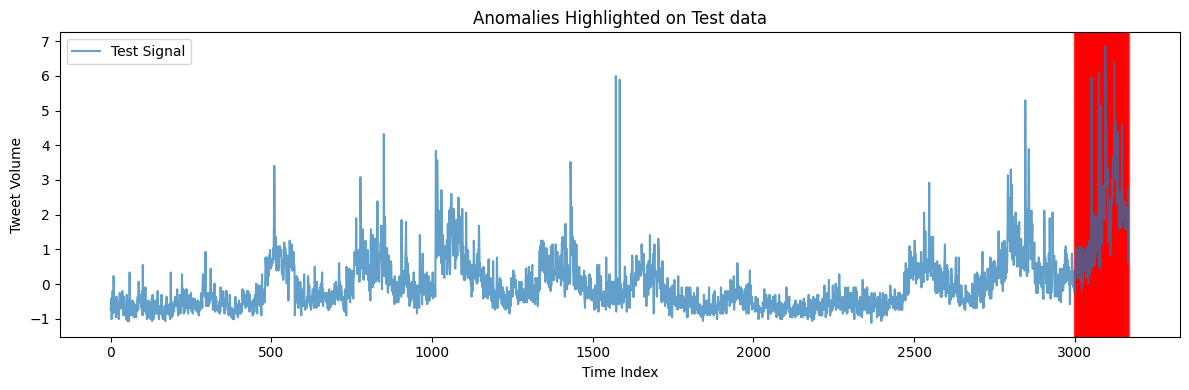

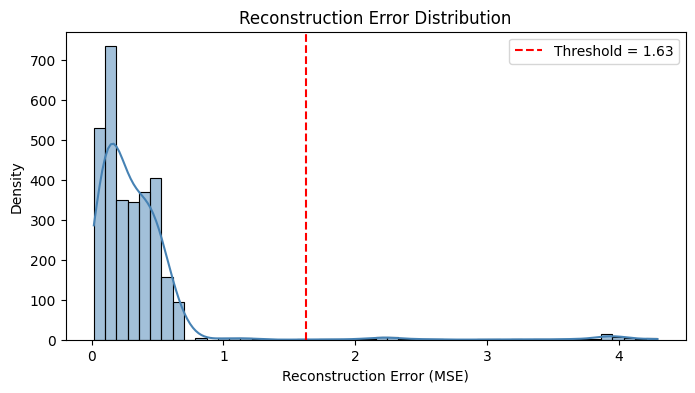

In [ ]:
test_series = test['N_Value'].values
test_windows = createSliding_windows(test_series, window_size)
test_windows = np.expand_dims(test_windows, axis=1)

test_tensor = torch.tensor(test_windows, dtype=torch.float32)
test_dataset = TensorDataset(test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

conv1d_autoencoder.eval()
test_errors = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)
        outputs = conv1d_autoencoder(inputs)
        errors = torch.mean((outputs - inputs) ** 2, dim=(1, 2))
        test_errors.extend(errors.cpu().numpy())

test_errors = np.array(test_errors)

test_anomalies = test_errors > threshold
anomaly_indices_test = np.where(test_anomalies)[0]

print(f"Anomalies detected in test set: {len(anomaly_indices_test)}")

test_signal = test['N_Value'].values

plt.figure(figsize=(12, 4))
plt.plot(test_signal, label='Test Signal', alpha=0.7)
for idx in anomaly_indices_test:
    start = idx
    end = idx + window_size
    plt.axvspan(start, end, color='red', alpha=0.3)
plt.title("Anomalies Highlighted on Test data")
plt.xlabel("Time Index")
plt.ylabel("Tweet Volume")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(test_errors, bins=50, kde=True, color='steelblue')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.2f}')
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Density")
plt.title("Reconstruction Error Distribution")
plt.legend()
plt.show()

In the first plot , The highlighted anomaly regions in the test signal clearly correspond to sharp spikes or unusual fluctuations in tweet volume, which supports the effectiveness of the model. The sharp spikes are anomalies and they are most encapsulated in the highlighted red region.

In the second plot , we can see that most of the errors are low , the peak of the distribution is near 0.2 and 0.4 , this means that the model reconstructs most normal data very well . There's a long tail on the right, the red treshold at 1.63 clearly seperates that rare high-error zone which also tells us that most data is well constrcuted , only small % has high error.

4. Discuss and analyze:

   - Describe your final RNN/LSTM architecture in detail (number of layers, types of layers, hidden size, dropout rate, etc.).

The encoder compresses the input sequence into a lower dimensional latent representation. It consists of a Conv1D layer with in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, followed by a LayerNorm([64, 50]) for stable training, and an ELU activation to introduce smooth non-linearity. This is followed by another Conv1D layer with in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=2, again followed by LayerNorm([128, 25]) and ELU activation. The third Conv1D layer has in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1 with LayerNorm([256, 13]) and ELU. The final Conv1D layer in the encoder has in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1, followed by LayerNorm([512, 7]) and ELU activation. Dropout is applied after each of the first three blocks with values 0.1, 0.2, and 0.2 respectively.

The bottleneck compresses the latent features using a fully connected layer: a Linear layer from 512×7 to 256 followed by ELU activation, and another Linear layer from 256 back to 512×7 to reshape into the decoder input format.

The decoder reconstructs the original input sequence from the latent representation. It consists of a ConvTranspose1D layer with in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, followed by LayerNorm([256, 14]) and ELU activation. This is followed by ConvTranspose1D with in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, LayerNorm([128, 28]) and ELU. Another ConvTranspose1D with in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, LayerNorm([64, 56]) and ELU. The final ConvTranspose1D layer has in_channels=64, out_channels=1, kernel_size=5, stride=2, padding=2, output_padding=1, followed by a Sigmoid activation to constrain the output between 0 and 1.

Training :
Loss Function  : MSE

Optimizer : Adam with learning rate of 1e-4

Batchsize : 32

Epochs: 50

Window size: 100

Dropout: Applied (0.1 → 0.2)

Normalization: LayerNorm

Activation: ELU

   - Discuss your results, referencing the metrics and visualizations. Did your model achieve the expected accuracy? What were the challenges? How did hyperparameter tuning affect performance? Are there any patterns in the errors (e.g., consistent under- or over-prediction)?

Our final model is a Conv1D Autoencoder designed for anomaly detection on time series data, specifically applied to the Twitter volume dataset over time. The training and validation loss curves show consistent convergence over the 50 epochs, with training loss decreasing from around 0.81 to 0.64 and validation loss stabilizing near 0.83. This indicates that the model learned meaningful representations of normal behavior without overfitting. On the test set, the reconstruction loss further dropped to approximately 0.35, suggesting the model’s strong generalization capability in accurately reconstructing normal patterns it hadn’t seen during training.

In terms of regression metrics, the model achieved a Mean Absolute Errorof 0.3975, a Root Mean Squared Error  of 0.5938, and an R-squared value  of 0.4693. These results reflect that the model is able to reconstruct the input signal well, with reasonable error margins for a time series anomaly detection task.

For anomaly detection, we analyzed the reconstruction error distribution from the validation set. The histogram of reconstruction errors was skewed with a clear tail of high error windows, as expected. We applied a hybrid thresholding strategy, comparing both the 90th percentile and Z-score thresholds. The model selected the 90th percentile value of 1.6247 as the final anomaly threshold. This approach ensured robustness by filtering only the top outliers while maintaining sensitivity to real anomalies.

Using this hybrid threshold, the model detected 307 anomalies across the entire dataset, including 73 anomalies in the test set. When visualized, these anomalies coincided with regions of sharp spikes in tweet volume, validating the models effectiveness in distinguishing abnormal patterns.

Although the model may miss a few minor anomalies or generate false positives near the threshold margin, it successfully captures the most important abnormal behaviors. Given the clean training/validation curves, strong test performance, well-separated reconstruction errors, and meaningful anomaly detections, we can conclude that this model is robust, interpretable, and practically useful for real-world anomaly detection tasks in time series data.

Challenges :
One of the main challenges we faced was getting the validation loss to go below a certain level. While the training loss steadily improved, the validation loss plateaued around 0.83, showing that the model was learning but not improving much on unseen data after a point. This suggests that the model might be approaching its learning capacity for the architecture we designed and dataset. We also observed that early epochs showed the biggest improvements, but after around epoch 10, the progress slowed down. It was important to choose a good threshold that balances sensitivity without detecting too many false positives.

HyperParameter Tuning and Error Patterns :
Hyperparameter tuning significantly contributed to improving the model’s performance. Lowering the learning rate to 1e-4 ensured stable and gradual convergence. We also enhanced the model’s capacity by increasing the number of convolutional filters (64, 128, 256, 512) and adopting deeper layers. Instead of standard batch normalization, we used Layer Normalization to better handle variable-length sequences. We switched the activation function to ELU for smoother gradients and incorporated Dropout at multiple stages to improve generalization. Additionally, a bottleneck with fully connected layers was introduced, enabling the model to compress and reconstruct richer latent representations. These enhancements made the model more expressive and robust, resulting in lower reconstruction errors.

In terms of error patterns, most high reconstruction errors appeared around sharp spikes or sudden fluctuations in the time series, which is expected in anomaly detection tasks. The model effectively detected pronounced anomalies but still showed slight underperformance when faced with very subtle or gradual deviations, which often fell just below the threshold. Nonetheless, the model consistently identified the most critical and visually apparent anomalies, demonstrating a strong alignment between error spikes and actual abnormal regions in the signal.

   - Discuss the strengths and limitations of using autoencoders for anomaly detection.

Using autoencoders for anomaly detection worked well in my case because the model was able to learn the normal patterns in the data and flag unusual behavior based on reconstruction error. Since the model is trained only in normal data, it becomes sensitive to anything that doesnt follow the learned patterns, which helps in detecting anomalies effectively. Also, we did not need labeled anomalies to train the model, which makes things easier. The way reconstruction error increases for anomalies makes it straightforward to set a threshold and identify error points.

Advantages :
No need for labeled anomalies during training, Can model complex patterns in sequential , Easy to detect anomalies by comparing input and output,  Can be built using LSTM, CNN, or dense layers based on the data type, Especially useful for capturing temporal dependencies.

Disadvantages :    
Starts reconstructing anomalies too well if overtrained,
Choosing the right error threshold for detection is tricky,
Hard to interpret why a point was marked as anomaly,
Sensitive to noise and needs well prepared input data.



#Observations :
We got a feedback from the checkpoint to increase the model layers and to consider a better tresholding strategy. We did work on it and with a focus on improving the accuracy , we did add residual layers along with the current architecture (which is also deeper layer compared to the one we submitted for checkpoint) but we noticed that even if we managed to get the loss to around 0.75, 0.7 , The evaluations metrics were way off with R square being in negative which is very bad sign so we reduced the few layers to arrive at the current evalaution metrics . Based on the graphs and evalaution metrics , the model is performing well with few outliers . The anomalies are being detected .

We have also used a hybrid tresholding strategy were we are choosing the best of z score thresholding or 90 percentile tresholding .

Since the output is not linear in nature , gaussian thresholding did not work well .

5. References. Include details on all the resources used to complete this part, e.g. links to datasets, research papers or articles, code examples or tutorials you referred.

Kaggle NAB dataset : https://www.kaggle.com/datasets/boltzmannbrain/nab?resource=download

Anomaly Detection with Autoencoders : https://www.sciencedirect.com/science/article/pii/S2666827024000483?dgcid=rss_sd_all

LSTM Autoencoder for Anomaly detection : https://youtu.be/6S2v7G-OupA?si=nIELbJbuOPQOn00L

pytorch documentation : https://pytorch.org/docs/stable/index.html


6. If you are working in a team, provide a contribution summary.

| Team Member | Step# | Contribution (%) |
|---|---|---|
| Kiran P Abraham  | Step 1 | 10 |
|  Aravind Mohan | Step 2 |  50 |
|Kiran P Abraham| Step 3 | 40 |
|   | **Total** |  100 |




Total - 100